In [1]:
"""
Caffe model is encoded into two files
1. Proto text file: https://github.com/s9xie/hed/blob/master/examples/hed/deploy.prototxt
2. Pretrained caffe model: http://vcl.ucsd.edu/hed/hed_pretrained_bsds.caffemodel
NOTE: In future, if these links do not work, I cannot help. Please Google 
and find updated links (information current as of October 2022)
"""

import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import data, io, img_as_ubyte, color
# cv2.__version__

In [2]:
# There is a Crop layer that the HED network uses which is not implemented by 
# default so we need to provide our own implementation of this layer.
#Without the crop layer, the final result will be shifted to the right and bottom
#cropping part of the image
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

In [3]:
!wget "https://upload.wikimedia.org/wikipedia/commons/c/c1/Beach_Stones_2.jpg"
# read the image of a plant seedling as grayscale from the outset
img = io.imread("Beach_Stones_2.jpg")

--2023-02-22 16:36:30--  https://upload.wikimedia.org/wikipedia/commons/c/c1/Beach_Stones_2.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273284 (267K) [image/jpeg]
Saving to: ‘Beach_Stones_2.jpg’

Beach_Stones_2.jpg  100%[===================>] 266.88K  --.-KB/s    in 0.07s   

2023-02-22 16:36:31 (3.91 MB/s) - ‘Beach_Stones_2.jpg’ saved [273284/273284]



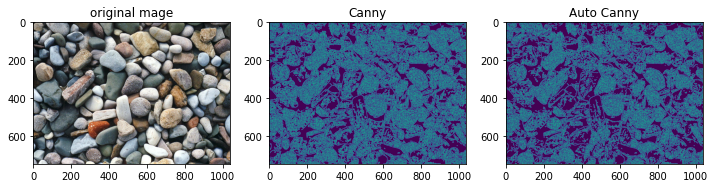

In [22]:
#Check traditional edge detectors first. e.g., canny, sobel, roberts, etc.

# load the input image and grab its dimensions, for future use while defining the blob
# img = cv2.imread("pebbles.jpg")
# plt.imshow(img)
#Canny
canny_edge = cv2.Canny(img,50,150)
# plt.imshow(canny_edge)
#Autocanny
sigma = 0.3
median = np.median(img)

# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - sigma) * median))
upper = int(min(255, (1.0 + sigma) * median))
auto_canny = cv2.Canny(img, lower, upper)
# plt.imshow(auto_canny)


plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title("original mage")
plt.imshow(img)
plt.subplot(132)
plt.title("Canny")
plt.imshow(canny_edge)
plt.subplot(133)
plt.title("Auto Canny")
plt.imshow(auto_canny)

--2023-02-22 16:36:36--  https://raw.githubusercontent.com/s9xie/hed/master/examples/hed/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8186 (8.0K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]   7.99K  --.-KB/s    in 0s      

2023-02-22 16:36:36 (107 MB/s) - ‘deploy.prototxt’ saved [8186/8186]

--2023-02-22 16:36:36--  https://github.com/ashukid/hed-edge-detector/raw/master/hed_pretrained_bsds.caffemodel
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ashukid/hed-edge-detector/master/hed_pretrained_bsds.caffemodel [following]
--2

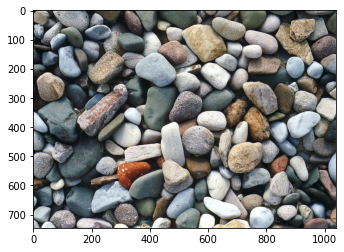

In [4]:
"""
Steps for edge detection using HED:
    
1. Define the network and load the pre-trained model.​
2. Create blob from the image – basically create a preprocessed image​
3. Load pretrained model (you need both the proto text and caffe model files)​
4. Pass the blob image through model​ (forward pass)
5. Get output​
"""
!wget "https://raw.githubusercontent.com/s9xie/hed/master/examples/hed/deploy.prototxt"
!wget "https://github.com/ashukid/hed-edge-detector/raw/master/hed_pretrained_bsds.caffemodel"
# The pre-trained model that OpenCV uses has been trained in Caffe framework
#Download from the link above
protoPath = "./deploy.prototxt"
modelPath = "./hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
# load the input image and grab its dimensions, for future use while defining the blob
# img = cv2.imread("pebbles.jpg")
plt.imshow(img)
(H, W) = img.shape[:2]

In [5]:
# register our crop layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

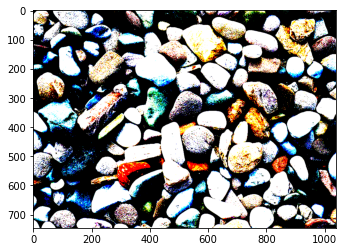

In [96]:

# construct a blob out of the input image 
#blob is basically preprocessed image. 
#OpenCV’s new deep neural network (dnn ) module contains two functions that 
#can be used for preprocessing images and preparing them for 
#classification via pre-trained deep learning models.
# It includes scaling and mean subtraction
#How to calculate the mean?
mean_pixel_values= np.average(img, axis = (0,1))
blob = cv2.dnn.blobFromImage(img, scalefactor=0.22, size=(W, H),
                             mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                            #  mean=(105, 117, 123),
                             swapRB= False, crop=False)

#View image after preprocessing (blob)
blob_for_plot = np.moveaxis(blob[0,:,:,:], 0,2)
plt.imshow(blob_for_plot)


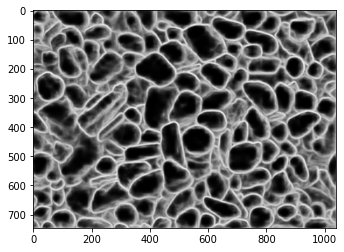

In [97]:
# set the blob as the input to the network and perform a forward pass
# to compute the edges
net.setInput(blob)
hed = net.forward()
hed = hed[0,0,:,:]  #Drop the other axes 
#hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")  #rescale to 0-255

plt.imshow(hed, cmap='gray')


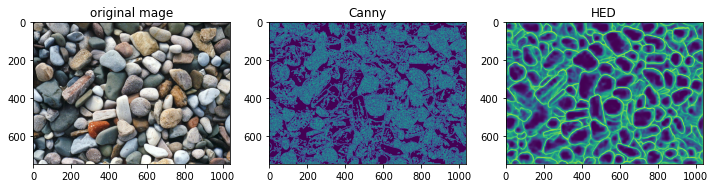

In [98]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title("original mage")
plt.imshow(img)
plt.subplot(132)
plt.title("Canny")
plt.imshow(auto_canny)
plt.subplot(133)
plt.title("HED")
plt.imshow(hed)

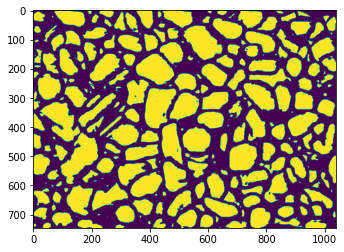

In [99]:
####################
#Connected component based labeling

# Load segmented binary image, Gaussian blur, grayscale, Otsu's threshold
blur = cv2.GaussianBlur(hed, (3,3), 0)

thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

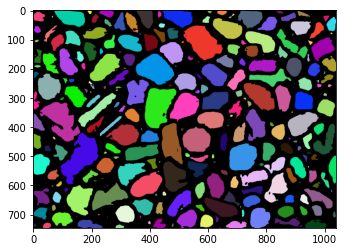

In [104]:
# Perform connected component labeling
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

# Create false color image with black background and colored objects
colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # black background
false_colors = colors[labels]
plt.imshow(false_colors)


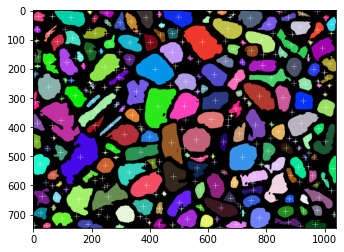

In [106]:
# Obtain centroids
false_colors_centroid = false_colors.copy()
for centroid in centroids:
    cv2.drawMarker(false_colors_centroid, (int(centroid[0]), int(centroid[1])),
                   color=(255, 255, 255), markerType=cv2.MARKER_CROSS)
plt.imshow(false_colors_centroid)

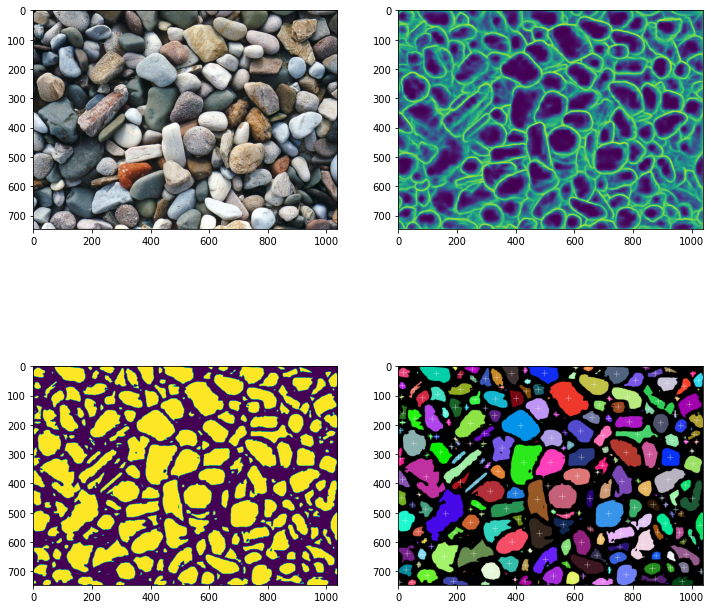

In [107]:
# Remove small objects
MIN_AREA = 50
false_colors_area_filtered = false_colors.copy()
for i, centroid in enumerate(centroids[1:], start=1):
    area = stats[i, 4]
    if area > MIN_AREA:
        cv2.drawMarker(false_colors_area_filtered, (int(centroid[0]), int(centroid[1])),
                       color=(255, 255, 255), markerType=cv2.MARKER_CROSS)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(hed)
plt.subplot(223)
plt.imshow(thresh)
plt.subplot(224)
plt.imshow(false_colors_area_filtered) 
plt.show()

In [108]:
#Alternatively, We can also use regionprops from skimage to extract various parameters

# regionprops function in skimage measure module calculates useful parameters for each object.
from skimage import measure
props = measure.regionprops_table(labels, intensity_image=img, 
                              properties=['label',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])
    
import pandas as pd
df = pd.DataFrame(props)

#Filter by size
df = df[df.area > 50]
df = df[df.area < 10000]

print(df.head())

   label  area  equivalent_diameter  mean_intensity-0  mean_intensity-1  \
0      1  4209            73.205637        160.118318        164.091708   
1      2   136            13.159049         20.705882         21.779412   
2      3   899            33.832563         75.776418         67.808676   
3      4  2469            56.068070        132.089915        138.341434   
4      5  4253            73.587280         76.096403         88.185516   

   mean_intensity-2  solidity  
0        168.665716  0.953773  
1         23.169118  0.944444  
2         54.244716  0.959445  
3        131.949372  0.959953  
4         80.071009  0.947005  
